In [18]:
%matplotlib inline

#FeatureSelectionByMultilevelEnrichmentImports
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy
from collections import Counter
from tqdm import tqdm
import warnings

import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
from chromograph.plotting.marker_plot import marker_plot
from chromograph.plotting.peak_annotation_plot import plot_peak_annotation_wheel
from chromograph.pipeline import config

import cytograph as cg
from cytograph.plotting.colors import colorize
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.species import Species

import fisher
import time

from scopen.MF import bounded_non_negative_factorization
from scopen.Utils import *
from scopen.__version__ import __version__

from typing import *

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import loompy
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.spatial.distance import jaccard

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

config = config.load_config()
sys.path.append("/home/camiel/anaconda3/envs/chromo/bin/")

In [11]:
f1 = '/proj/DEV_ATAC/PBMC_20200825/All/All_peaks.loom'
f2 = '/proj/DEV_ATAC/PBMC_20200825/All/All_peaks.agg.loom'

n_components = 30
max_iter = 500
min_rho = 0.0
max_rho = 0.5
decimals = 8
alpha = 1

time.time()

with loompy.connect(f1, 'r') as ds:

    data = ds.layer[''].sparse().tocsr()
    (m, n) = ds.shape

    n_open_regions = np.log10(ds.map([np.sum], axis=1)[0])
    max_n_open_regions = np.max(n_open_regions)
    min_n_open_regions = np.min(n_open_regions)
    
    logging.info("Number of peaks: {}; number of cells {}".format(m, n))
    logging.info("Sparsity before imputation: {}".format(1 - np.sum(ds.map([np.count_nonzero], axis=1)[0]) / (m * n)))


    rho = min_rho + (max_rho - min_rho) * \
          (max_n_open_regions - n_open_regions) / (max_n_open_regions - min_n_open_regions)

#     data = data[:, :] * (1 / (1 - rho))
    data = data * (1 / (1 - rho))
    
    w_hat, h_hat, _ = bounded_non_negative_factorization(X=data,
                                                         n_components=n_components,
                                                         alpha=alpha,
                                                         max_iter=max_iter,
                                                         verbose=1)
    del data
    m_hat = np.dot(w_hat, h_hat)
    np.clip(m_hat, 0, 1, out=m_hat)
    np.round(m_hat, decimals=decimals, out=m_hat)

#     df = pd.DataFrame(data=w_hat, index=peaks)
#     df = pd.DataFrame(data=h_hat, columns=barcodes)

#     if args.output_format == "sparse":
#         filename = os.path.join(args.output_dir, "{}.txt".format(args.output_prefix))
#         write_data_to_sparse_file(filename=filename, data=m_hat, barcodes=barcodes, peaks=peaks)

    print("Sparsity after imputation: {}".format(1 - np.count_nonzero(m_hat) / (m * n)))
    secs = time.time() - start
    m, s = divmod(secs, 60)
    h, m = divmod(m, 60)

    logging.info("[total time: ", "%dh %dm %ds" % (h, m, s), "]")


14:35:43 INFO     Number of peaks: 142522; number of cells 8619
14:35:56 INFO     Sparsity before imputation: 0.9484368319724437


violation: 1.0
violation: 0.2199171385920918
violation: 0.08735196735458838
violation: 0.061887284160256496
violation: 0.05065111083039396
violation: 0.04284784463132876
violation: 0.036987510784213855
violation: 0.03207729648424357
violation: 0.02814349593639472
violation: 0.024837101103872713
violation: 0.0221752704815803
violation: 0.02001822282826853
violation: 0.018210502023003106
violation: 0.01671285650515393
violation: 0.015525277562766775
violation: 0.014501165739152087
violation: 0.013589605528842617
violation: 0.012858636549275647
violation: 0.012181118422316863
violation: 0.01157906151662712
violation: 0.011074983398432077
violation: 0.01062189968340044
violation: 0.010200411738900832
violation: 0.0098062849428696
violation: 0.009448464339611587
violation: 0.009092548157781951
violation: 0.00877374705307911
violation: 0.008456983394029489
violation: 0.008140901932822167
violation: 0.007839082045107859
violation: 0.0075356049636034535
violation: 0.007247174162317021
violatio

NameError: name 'start' is not defined

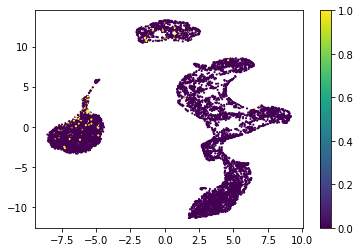

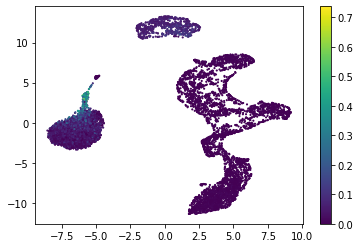

In [22]:
with loompy.connect(f1) as ds:
    with loompy.connect(f2) as dsout:
        p = np.where(dsout.ra.markerPeaks)[0][1]

        plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c=ds.layers[''][p,:], s=5,  marker='.')
        plt.colorbar()
        
        plt.figure()
        plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c=m_hat[p,:], s=5,  marker='.')
        plt.colorbar()
        
#         print(np.unique(ds.layers[''][p,:]))
#         print(np.unique(ds.layers['pooled'][p,:]))
        
#         print(np.sum(ds.layers[''][p,:]))
#         print(np.sum(ds.layers['pooled'][p,:] > 0))

In [17]:
plt.scatter([0,1], [1,1])